In [1]:
from brian2 import *
#from brian2tools import *
import numpy as np
%matplotlib inline

In [2]:
# SIMULATION PARAMETERS

prefs.codegen.target = 'numpy'
# the numerical resolution method that shall be used by Brian
diff_method = "euler"
time_step = 0.01 * ms
defaultclock.dt = time_step 

In [3]:
################################## NEURONS AND SYNAPSES PARAMETERS ################################## 

######### (A) Neuronal parameters, used in (1) and (4) ########

# time constants
tau_m = 1.0 * ms # ok
tau_m_inh = 0.5 * ms # ok
# membrane potential after reset
v_rest = 0.0 # ok
# spiking threshold
theta_u = 0.5 # ok
theta_inh = 0.01 # ok

########## (B) Synaptic parameters, used in (2) and (3) for different synapse types ######### 

# temporal layer to som layer (u to v)
tau_r_afferent = 0.2 * ms
tau_f_afferent = 1.0 * ms

# temporal layer (u to inh exc, u to inh inh, inh to u)
tau_r_exc = 0.4 * ms
tau_f_exc = 2.0 * ms
tau_r_inh = 0.2 * ms
tau_f_inh = 1.0 * ms
tau_r_inh2u = 1.0 * ms
tau_f_inh2u = 5.0 * ms

########## (C) Maximum magnitudes of synaptic connection strength ########## poids synaptique
w_syn_u2inh_exc_max = 1.0
w_syn_u2inh_inh_max = 1.0
w_syn_inh2u_max = 100.0

In [4]:
class ReceptiveField:
    # Parameter used in standard deviation definition
    gamma = 1.5

    def __init__(self, bank_size = 10, I_min =0.05 , I_max =0.95 ):
        # number of units used to encode a real value  
        self.bank_size = bank_size
        # field_mu corresponds to the mean of the gaussian and shall be a numpy array 
        self.field_mu = np.zeros(bank_size)
        for i in range (bank_size): 
            mui = I_min + (((2*(i+1)-2)/2)*(I_max - I_min)/(bank_size-1))
            self.field_mu[i] = mui
        # field_sigma corresponds to the standard deviation of the gaussian and shall be a float
        self.field_sigma = 1/self.gamma * (I_max - I_min)
        
    def float_to_potential(self, input_vector):
        try:
            input_vector = input_vector.reshape((input_vector.shape[0], 1))
            #self.field_mu = self.field_mu.reshape((self.field_mu.shape[0], 1))
            
        except Exception as exc:
            print("Exception: {0}\nObject shape: {1}".format(repr(exc), input_vector.shape))
            exit(1)
            
        #résultat de f(x)
        result = e**(-((input_vector - self.field_mu)**2) /(2*self.field_sigma)) ### VERIF
        return result

In [5]:
rf = ReceptiveField()
inp_size = 2
inp_vector = np.random.uniform(0,1,inp_size)
inp_vector = np.array([0.2,0.6])

In [6]:
rf.field_sigma  # 0.59999999

0.5999999999999999

In [7]:
inp_potentials = rf.float_to_potential(inp_vector) 
inp_potentials

array([[0.98142469, 0.99791884, 0.99791884, 0.98142469, 0.94924976,
        0.9029543 , 0.84472006, 0.77717997, 0.70322152, 0.62578401],
       [0.77717997, 0.84472006, 0.9029543 , 0.94924976, 0.98142469,
        0.99791884, 0.99791884, 0.98142469, 0.94924976, 0.9029543 ]])

## notes séance 06/02
c'est le temps d'émission qui encode l'information 
c'est une propagation 

Tous les neurones sont les mêmes dans u et v c'est les mêmes modèles mais avec des paramètre différents 
fèche exitateur
flèche plate inhibiteur 

c'est dans le modèle des synapse qu'on mettra les fonctions alpha 
u = à la somme des poids des synapses 
w le poids synaptique

fonctions alpha les règles des synapses 

pas obligé de faire l'apprentissage dans un premier temps 

eq 5 : adapter les poids synaptiques
    --> en fonction de ce qui est reçu on applique une règle ou l'autre 
    
    
summed variable sert pour l'eq 4 

eq 6 : implémenter la différence de gaussienne --> partie 5 de l'aide

eq 7 réduire le rayon au cours du temps
    T n'est pas donné (essayer 10 on peut jouer avec)
    n non plus n=1 on peut essayer de le faire varier 

In [8]:
# à adapter, peret de calculer la distance toroidale
# permet de calculer le vecteur d'entrée de u
# implémenter le noyer d'interraction pour la pop v
def toroidalDistance(x1,x2):
    dx = np.abs(x1 - x2)
    tor_dist = np.where(dx < 0, dx, 1.0 - dx)
    return tor_dist

In [9]:
##### sans inh #####
u_layer_neuron_equ = '''
I_ext : 1

# membrane potential of u layer 
dv/dt = (-v +I_ext) / tau_m:1
'''


inhibition_neuron_equ = '''
    # inhibitory synapses to inh neuron : alpha functions
    ds_u2inh_inh/dt = (-s_u2inh_inh)/tau_r_inh:1
    dI_u2inh_inh/dt = (s_u2inh_inh-I_u2inh_inh)/tau_f_inh :1

    # exitatory synapses to inh neuron : alpha functions
    ds_u2inh_ext/dt = (-s_u2inh_ext)/tau_r_exc:1
    dI_u2inh_ext/dt = (s_u2inh_ext-I_u2inh_ext)/tau_f_exc :1
    
    # membrane potential of inh neuron
    dv/dt = (-v + I_u2inh_ext - I_u2inh_inh) / tau_m_inh:1
'''
    
    
#trucs pas définis (à cause de l'adapatation à brian): ds_inh2u, dI_inh2u
# variables : s_inh2u, I_inh2u
# s = 0 la présence d'un spike présynaptique
# s1 = s_inh2u internal state variable
# s2 = I_inh2u alpha function output
    

In [10]:
N = 10 * inp_size
u_layer = NeuronGroup(N,u_layer_neuron_equ, threshold='v>0.5', reset='v=0', method='exact')

inhibition_neuron = NeuronGroup(1,inhibition_neuron_equ, threshold='v>0.5', reset='v=0', method='exact')

In [11]:
# N de U = 10* input size\n",
# la sortie de de U doit être 1dim de taille 20
# I_ext  doit être 1 dim --> funct flatten()
u_layer.I_ext = inp_potentials.flatten()

In [12]:
model_synapse_inh2u_inhibition = '''
w_syn : 1
'''    
on_pre_synapse_inh2u_inhibition = '''
s_inh2u += w_syn
'''

model_synapse_u2inh_exitation = '''
w_syn : 1
'''
on_pre_synapse_u2inh_exitation = '''
s_u2inh_ext += w_syn
'''

model_synapse_u2inh_inhibition = '''
w_syn : 1
'''
on_pre_synapse_u2inh_inhibition = '''
s_u2inh_inh += w_syn
'''


#définir le modèle de synapse
u2inh_exitation = Synapses(u_layer, 
                            inhibition_neuron,
                            model_synapse_u2inh_exitation,
                            on_pre=on_pre_synapse_u2inh_exitation)
u2inh_inhibition = Synapses(u_layer, 
                            inhibition_neuron,
                            model_synapse_u2inh_inhibition,
                            on_pre=on_pre_synapse_u2inh_inhibition)



## faire les connextions 
u2inh_exitation.connect()
u2inh_inhibition.connect()
#inh2u_inhibition.connect()

## pour l'instant poids synaptiques constants (je sais pas si ça changera ni comment)
u2inh_exitation.w_syn = w_syn_u2inh_exc_max
u2inh_inhibition.w_syn = w_syn_u2inh_inh_max
#inh2u_inhibition.w_syn = w_syn_inh2u_max

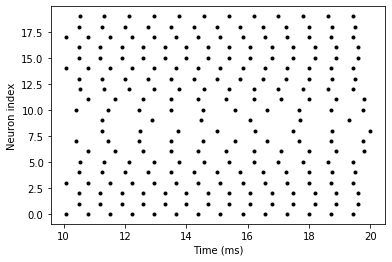

In [14]:
spikemon = SpikeMonitor(u_layer, variables='v')
run(10*ms)
plot(spikemon.t/ms, spikemon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

In [ ]:
# partie copiée de la partie 6 aide
net_model = Network(collect())
net_model.store()

for epoch in range (nb_epoch):
    np.random.shuffle(dataset)
    for vector in enumerate(dataset):
        for oscil in range(nb_oscil):
            net_model.restore()
            potential_input = rf.float_to_membrane_potential(vector)
            u_layer.I_ext = potential_input.flatten()
            net_model.run(oscillation_period)
            net_model.store()

U va convertir une valeure en motif spacio temporel 
l'apprentissage se situe entre U et V 
si y a pas inh : U se désincronise 
--> but: ne pas perdre le motif, on veut que le cycle se reproduise à l'identique 
    Inh va détecter la fin de la séquence offsetdetector (il y a aussi onset detector), en offset il va inhibier toutes les dissonances pour qu'il y ai toujours le motif 
    
Pour le renforcement : on prend le signe de delta w 

I : tableau 2 dimentions normalisé (entre 0 et 1)
On veut encoder ces valeures là de façon spacio-temporelle avec le temps d'émiion des spikes
On va donc la représenter avec une banque de 10 neurones 
